In [4]:
import numpy as np
import pandas as pd
import scipy as sp

from src.metrics import compute_metrics

In [5]:
df = pd.read_csv('data/v3.csv', index_col=0)

target_features = ['hour' + str(idx) for idx in range(48)]
df = df.astype(np.float32)

df[target_features] = df[target_features].divide(df['sum_costs'], axis=0)

np.random.seed(48)

inds = np.arange(df.shape[0])
np.random.shuffle(inds)

df = df.iloc[inds, :]
df.head()

,day_of_week,hour0,hour1,hour10,hour11,hour12,hour13,hour14,hour15,hour16,hour17,hour18,hour19,hour2,hour20,...,hour40,hour41,hour42,hour43,hour44,hour45,hour46,hour47,hour5,hour6,hour7,hour8,hour9,hour_of_day,sum_costs
10730,3.0,0.588235,0.058824,0.000000,0.000000,0.0,0.0,0.058824,0.0,0.000000,0.0,0.0,0.0,0.117647,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.117647,0.000000,0.0,0.0,19.0,6379.661621
12903,7.0,0.428571,0.428571,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.142857,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,6.0,1816.676392
5301,5.0,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.500000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,20.0,254.445618
2040,6.0,0.142857,0.285714,0.095238,0.047619,0.0,0.0,0.000000,0.0,0.047619,0.0,0.0,0.0,0.095238,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.047619,0.0,0.0,19.0,3122.307129
11499,3.0,0.333333,0.555556,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.055556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,7.0,540.015991


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

from src.data import AdDataset

dataset = AdDataset(df)

model = LinearRegression()

# cv_model = GridSearchCV(
#     model,
#     scoring=lambda estimator, x, y: -compute_metrics(estimator.predict(x), y)['hellinger'])

-cross_val_score(
    model,
    dataset.x,
    dataset.y,
    scoring=lambda estimator, x, y: -compute_metrics(estimator.predict(x), y)['hellinger'],
    cv=5
).mean()


/home/daniilkk/dev/friends/dimon/money_dist_tg/src/metrics.py:14: RuntimeWarning: invalid value encountered in sqrt
  return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2
/home/daniilkk/dev/friends/dimon/money_dist_tg/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:842: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/daniilkk/dev/friends/dimon/money_dist_tg/venv/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_33648/1249626818.py", line 18, in <lambda>
    scoring=lambda estimator, x, y: -compute_metrics(estimator.predict(x), y)['hellinger'],
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/daniilkk/dev/friends/di

nan

In [7]:
model = LinearRegression()

model.fit(dataset.x, dataset.y)

compute_metrics(model.predict(dataset.x), dataset.y)['hellinger']

LinearRegression()

0.5173424847147792

In [8]:
full_mean = df.groupby(['day_of_week', 'hour_of_day'])[target_features].mean()
full_median = df.groupby(['day_of_week', 'hour_of_day'])[target_features].median()

hour_mean = df.groupby(['hour_of_day'])[target_features].mean()
hour_median = df.groupby(['hour_of_day'])[target_features].median()

In [13]:
def apply_fn(groupby_agg: pd.DataFrame, row):
    g1 = groupby_agg.loc[row['day_of_week']]
    return g1.loc[row['hour_of_day']] if 'hour_of_day' in g1.index else np.zeros(48)

class Asstimator:
    def __init__(self, is_full: bool, is_mean: bool):
        self.is_full = is_full
        # self.by = ['day_of_week', 'hour_of_day'] if is_full else ['hour_of_day']
        self.is_mean = is_mean
    
    def fit(self, x, y):
        data = pd.concat((x, y), axis=1)

        groupby = data.groupby(by=['day_of_week', 'hour_of_day'] if self.is_full else ['hour_of_day'])[target_features]

        self.groupby_agg = groupby.mean() if self.is_mean else groupby.median()

    def predict(self, x):
        if self.is_full:
            
            return x.apply(lambda row: apply_fn(self.groupby_agg, row), axis=1)
            # return x.apply(lambda row: self.groupby_agg.loc[row['day_of_week']].loc[row['hour_of_day']], axis=1)
        else:
            return x.apply(lambda row: self.groupby_agg.loc[row['hour_of_day']], axis=1)


In [10]:
# full_mean.loc[1.0].loc[22.0].to_numpy()

full_mean_pred = df.apply(lambda row: full_mean.loc[row['day_of_week']].loc[row['hour_of_day']], axis=1)
full_median_pred = df.apply(lambda row: full_median.loc[row['day_of_week']].loc[row['hour_of_day']], axis=1)

hour_mean_pred = df.apply(lambda row: hour_mean.loc[row['hour_of_day']], axis=1)
hour_median_pred = df.apply(lambda row: hour_median.loc[row['hour_of_day']], axis=1)

In [11]:
from copy import deepcopy

def cv_score(estimator, x, y, n_folds):
    # df = pd.concat((x, y), axis=1)
    x_folds = np.array_split(x, n_folds)
    y_folds = np.array_split(y, n_folds)
    
    scores = []

    for idx, (x_val, y_val) in enumerate(zip(x_folds, y_folds)):
        print(f'CV fold {idx}')
        x_train = pd.concat([fold for fold in x_folds if fold is not x_val])
        y_train = pd.concat([fold for fold in y_folds if fold is not y_val])

        est = deepcopy(estimator)
        est.fit(x_train, y_train)
        pred = est.predict(x_val)

        score = compute_metrics(pred.to_numpy(), y_val.to_numpy())["hellinger"]
        scores.append(score)
    
    return np.array(scores)

In [14]:
x_features = ['day_of_week', 'hour_of_day']

# for seed in range(10000):
#     print(seed)
#     # SEED = 38
#     try: 
np.random.seed(42)
inds = np.arange(df.shape[0])
np.random.shuffle(inds)
df = df.iloc[inds, :]

full_mean_pred = cv_score(Asstimator(True, True), df[x_features], df[target_features], n_folds=5).mean()
full_median_pred = cv_score(Asstimator(True, False), df[x_features], df[target_features], n_folds=5).mean()
hour_mean_pred = cv_score(Asstimator(False, True), df[x_features], df[target_features], n_folds=5).mean()
hour_median_pred = cv_score(Asstimator(False, False), df[x_features], df[target_features], n_folds=5).mean()

print(f'full_mean_pred: {full_mean_pred:.3f}')
print(f'full_median_pred: {full_median_pred:.3f}')
print(f'hour_mean_pred: {hour_mean_pred:.3f}')
print(f'hour_median_pred: {hour_median_pred:.3f}')
    # except:
    #     continue


/home/daniilkk/dev/friends/dimon/money_dist_tg/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


CV fold 0
CV fold 1
CV fold 2
CV fold 3
CV fold 4


/home/daniilkk/dev/friends/dimon/money_dist_tg/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


CV fold 0
CV fold 1
CV fold 2
CV fold 3
CV fold 4


/home/daniilkk/dev/friends/dimon/money_dist_tg/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


CV fold 0
CV fold 1
CV fold 2
CV fold 3
CV fold 4


/home/daniilkk/dev/friends/dimon/money_dist_tg/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


CV fold 0
CV fold 1
CV fold 2
CV fold 3
CV fold 4
full_mean_pred: 0.707
full_median_pred: 0.707
hour_mean_pred: 0.514
hour_median_pred: 0.467


array([  26,   32,   35,   37,   52,   91,  103,  124,  127,  443,  529,
        645,  713,  722,  735,  783,  789,  810,  823,  861, 1051, 1423,
       1642, 1720])

<Axes: >

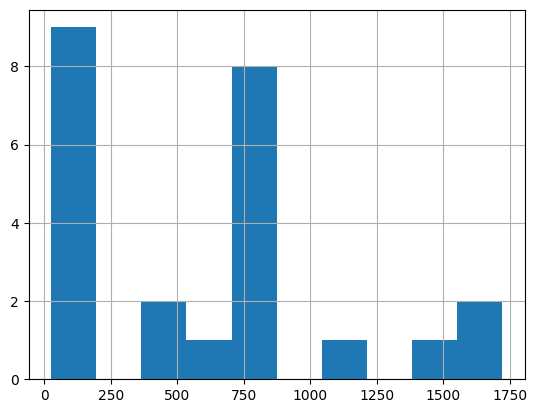

In [27]:
df.groupby('hour_of_day')['hour0'].count().reset_index()['hour0'].sort_values().head(30).to_numpy()

df.groupby('hour_of_day')['hour0'].count().reset_index()['hour0'].hist()


In [30]:
hour_mean.to_excel('experiments/hour_mean.xlsx')